In [1]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import numpy as np

# Preparing a datset for supervised insturction finetuning

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [3]:
print("example entry:\n", data[50])

example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
print("example entry:\n", data[999])

example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Reseponse:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Reseponse:
The correct spelling is 'Occasion.'


In [7]:
# formatted response without an input field
model_input = format_input(data[999])
desired_response = f"\n\n### Reseponse:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
What is an antonym of 'complicated'?

### Reseponse:
An antonym of 'complicated' is 'simple'.


In [8]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion+test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


# Organizing data into training batches

In [10]:
from mlx_lm import load
model_hf, tokenizer_hf = load("openai-community/gpt2-medium")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
class InstructionDataset:
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [12]:
def custom_collate_draft_1(batch, pad_token_id=50256):
    # find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra padding token
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # remove the extra padded token that has been added via the +1 setting in batch_max_length
        inputs = padded[:-1]
        inputs_lst.append(inputs)
    
    inputs_tensor = mx.stack(mx.array(inputs_lst), axis=0)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1, inputs_2, inputs_3
)
print(custom_collate_draft_1(batch))

array([[0, 1, 2, 3, 4],
       [5, 6, 50256, 50256, 50256],
       [7, 8, 9, 50256, 50256]], dtype=int32)


In [14]:
def custom_collate_draft_2(batch, pad_token_id=50256):
    # find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra padding token
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []
    targets_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # remove the extra padded token that has been added via the +1 setting in batch_max_length
        inputs = padded[:-1]
        inputs_lst.append(inputs)
        # shift +1 to the right for targets
        targets = padded[1:]
        targets_lst.append(targets)
    
    inputs_tensor = mx.stack(mx.array(inputs_lst), axis=0)
    targets_tensor = mx.stack(mx.array(targets_lst), axis=0)
    return inputs_tensor, targets_tensor

In [15]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1, inputs_2, inputs_3
)
print(custom_collate_draft_2(batch))

(array([[0, 1, 2, 3, 4],
       [5, 6, 50256, 50256, 50256],
       [7, 8, 9, 50256, 50256]], dtype=int32), array([[1, 2, 3, 4, 50256],
       [6, 50256, 50256, 50256, 50256],
       [8, 9, 50256, 50256, 50256]], dtype=int32))


In [16]:
def custom_collate_fn(batch,
                      pad_token_id=50256,
                      ignore_index=-100,
                      allowed_max_length=None
):
    # find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra padding token
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []
    targets_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # remove the extra padded token that has been added via the +1 setting in batch_max_length
        inputs = mx.array(padded[:-1])
        # shift +1 to the right for targets
        targets = mx.array(padded[1:])

        # replace all but the first padding tokens in targets by ignore_index
        mask = []
        n_ignore = 0
        for x in targets:
            if x == pad_token_id:
                n_ignore += 1
                if n_ignore > 1:
                    mask.append(False)
                else:
                    mask.append(True)
            else:
                mask.append(True)
        mask = mx.array(mask)
        targets = mx.where(mask, targets, ignore_index)
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = mx.stack(mx.array(inputs_lst), axis=0)
    targets_tensor = mx.stack(mx.array(targets_lst), axis=0)
    return inputs_tensor, targets_tensor

In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1, inputs_2, inputs_3
)
print(custom_collate_fn(batch))

(array([[0, 1, 2, 3, 4],
       [5, 6, 50256, 50256, 50256],
       [7, 8, 9, 50256, 50256]], dtype=int32), array([[1, 2, 3, 4, 50256],
       [6, 50256, -100, -100, -100],
       [8, 9, 50256, -100, -100]], dtype=int32))


In [18]:
logits_1 = mx.array(
    [[-1.0, 1.0], [-0.5, 1.5]]
)
targets_1 = mx.array([0, 1])
loss_1 = nn.losses.cross_entropy(logits_1, targets_1, reduction="mean")
print(loss_1)

array(1.12693, dtype=float32)


In [19]:
logits_2 = mx.array(
    [[-1.0, 1.0], [-0.5, 1.5], [-0.5, 1.5]]
)
targets_2 = mx.array([0, 1, 1])
loss_2 = nn.losses.cross_entropy(logits_2, targets_2, reduction="mean")
print(loss_2)

array(0.793595, dtype=float32)


In [20]:
targets_3 = mx.array([0, 1, -100])
loss_3 = nn.losses.cross_entropy(logits_2, targets_3, reduction="none")
loss_3_mask = targets_3 != -100
loss_3 = (loss_3 * loss_3_mask).sum() / loss_3_mask.sum()
print("loss_1==loss_3", loss_1==loss_3, loss_1, loss_3)

loss_1==loss_3 array(True, dtype=bool) array(1.12693, dtype=float32) array(1.12693, dtype=float32)


# Creating data loaders for an instruction dataset

In [21]:
class DataLoaderNP:
    def __init__(self, dataset, batch_size, 
                 shuffle, drop_last, seed=None, 
                 collate_fn=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.seed = seed
        self.collate_fn = collate_fn
    
    def __call__(self):
        indices = np.arange(len(self.dataset))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            indices = np.random.permutation(indices)

        # collect batches from the dataset
        for i in range(0, len(indices) - self.batch_size+1, self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            batch = [self.dataset[idx] for idx in batch_indices]
            if self.collate_fn is not None:
                input_ids, target_ids = self.collate_fn(batch)
            # print(input_ids, target_ids)
            yield {
                "input_ids": mx.array(input_ids, dtype=mx.int32),
                "target_ids": mx.array(target_ids, dtype=mx.int32),
            }
    
    def __len__(self):
        n_batches = len(self.dataset)//self.batch_size
        if not self.drop_last:
            n_batches += int(len(self.dataset) % self.batch_size != 0)
        return n_batches

    def __iter__(self):
        return self.__call__()


In [22]:
batch_size = 8
train_dataset = InstructionDataset(train_data, tokenizer_hf)
train_loader = DataLoaderNP(
    train_dataset, batch_size,
    shuffle=True, drop_last=True, seed=123,
    collate_fn=custom_collate_fn
)

In [23]:
print("Train loader:")
for batch in train_loader:
    print(batch['input_ids'].shape, batch['target_ids'].shape)
    # pass
# print("Input batch dimensions:", batch["input_ids"].shape)
# print("Target batch dimensions:", batch["target_ids"].shape)

Train loader:
(8, 90) (8, 90)
(8, 66) (8, 66)
(8, 70) (8, 70)
(8, 71) (8, 71)
(8, 71) (8, 71)
(8, 69) (8, 69)
(8, 58) (8, 58)
(8, 58) (8, 58)
(8, 64) (8, 64)
(8, 92) (8, 92)
(8, 61) (8, 61)
(8, 68) (8, 68)
(8, 65) (8, 65)
(8, 70) (8, 70)
(8, 75) (8, 75)
(8, 75) (8, 75)
(8, 61) (8, 61)
(8, 61) (8, 61)
(8, 80) (8, 80)
(8, 84) (8, 84)
(8, 63) (8, 63)
(8, 69) (8, 69)
(8, 81) (8, 81)
(8, 63) (8, 63)
(8, 72) (8, 72)
(8, 66) (8, 66)
(8, 81) (8, 81)
(8, 62) (8, 62)
(8, 74) (8, 74)
(8, 70) (8, 70)
(8, 68) (8, 68)
(8, 69) (8, 69)
(8, 61) (8, 61)
(8, 66) (8, 66)
(8, 81) (8, 81)
(8, 67) (8, 67)
(8, 66) (8, 66)
(8, 78) (8, 78)
(8, 69) (8, 69)
(8, 70) (8, 70)
(8, 67) (8, 67)
(8, 69) (8, 69)
(8, 69) (8, 69)
(8, 69) (8, 69)
(8, 89) (8, 89)
(8, 92) (8, 92)
(8, 64) (8, 64)
(8, 60) (8, 60)
(8, 66) (8, 66)
(8, 68) (8, 68)
(8, 84) (8, 84)
(8, 64) (8, 64)
(8, 59) (8, 59)
(8, 72) (8, 72)
(8, 63) (8, 63)
(8, 62) (8, 62)
(8, 75) (8, 75)
(8, 78) (8, 78)
(8, 84) (8, 84)
(8, 63) (8, 63)
(8, 76) (8, 76)
(8, 59) (8

In [24]:
print("Example input IDs:", batch["input_ids"][0])

Example input IDs: array([21106, 318, 281, ..., 50256, 50256, 50256], dtype=int32)


In [25]:
print("Example target IDs:", batch["target_ids"][0])

Example target IDs: array([318, 281, 12064, ..., -100, -100, -100], dtype=int32)


In [26]:
val_dataset = InstructionDataset(val_data, tokenizer_hf)
val_loader = DataLoaderNP(
    val_dataset, batch_size,
    shuffle=True, drop_last=True, seed=123,
    collate_fn=custom_collate_fn
)
test_dataset = InstructionDataset(test_data, tokenizer_hf)
test_loader = DataLoaderNP(
    test_dataset, batch_size,
    shuffle=True, drop_last=True, seed=123,
    collate_fn=custom_collate_fn
)

# Test the loaded pretrained LLM

In [27]:
from mlx_lm import generate

# the model is not capable of follwing the instructions, yet.
input_text = format_input(val_data[0])
print(input_text)
generate(model_hf, tokenizer_hf, prompt=input_text)


Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


"\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instru

# Finetuning the LLM on instruction data

In [28]:
def compute_ce_loss(model, inputs, target):
    logits = model(inputs)
    loss = nn.losses.cross_entropy(logits.flatten(0, 1), target.flatten(),
                                   reduction="mean")
    return loss

def calc_loss_batch(input_batch, target_batch, model, no_grad, device=None):
    input_batch, target_batch = mx.array(input_batch), mx.array(target_batch)

    if no_grad:
        input_batch = mx.stop_gradient(input_batch)
    # logits = model(input_batch)
    batch_step_fn = nn.value_and_grad(model, compute_ce_loss)
    loss, grad = batch_step_fn(model, input_batch, target_batch)
    return loss, grad

def calc_loss_loader(data_loader, model, no_grad, device=None, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, ex in enumerate(iter(data_loader)):
        if i < num_batches:
            loss, _ = calc_loss_batch(ex['input_ids'], ex['target_ids'], model, no_grad)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches    

In [29]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = mx.array(encoded)[None, :]
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze().tolist()
    return tokenizer.decode(flat)

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens)array of indices in the current context.
    for _ in range(max_new_tokens):
        # get current context within the context window
        idx_cond = idx[:, -context_size:]
        # get the predictions
        logits = model(mx.stop_gradient(idx_cond))
        # focus on the last time step
        logits = logits[:, -1, :]
        probas= mx.softmax(logits, axis=-1)
        # get the idx of the vocab entry with the highest probability
        idx_next = mx.argmax(probas, axis=-1, keepdims=True)
        # append sampled index to the sequence
        idx = mx.concat([idx, idx_next], axis=1)
    return idx

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, 0

    for epoch in range(num_epochs):
        # mx.eval(model.parameters())
        model.train()
        for batch in iter(train_loader):
            input_batch, target_batch = batch['input_ids'], batch['target_ids']
            loss, grads = calc_loss_batch(input_batch, target_batch, model, no_grad=False)
            optimizer.update(model, grads)
            # Force a graph evaluation
            # mx.eval(model.parameters(), optimizer.state)
            # mx.eval(model.state)
            mx.eval(loss, [model.state, optimizer.state])
            tokens_seen += input_batch.size
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, step {global_step:06d}: "
                      f"train loss {train_loss:.3f}, val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
        # print(f"Epoch {epoch+1}, Loss: {loss.item():.3f}, Tokens seen: {tokens_seen}")
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    train_loss = calc_loss_loader(train_loader, model, True, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, True, device, eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.model.wpe.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer)
    token_ids = generate_text_simple(
        model=model,
        idx=mx.stop_gradient(encoded),
        max_new_tokens=50,
        context_size=context_size,
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [30]:
train_loss = calc_loss_loader(train_loader, model_hf, no_grad=True, num_batches=5)
print("Train loss (5 batches):", train_loss)
val_loss = calc_loss_loader(val_loader, model_hf, no_grad=True, num_batches=5)
print("Val loss (5 batches):", val_loss)

Train loss (5 batches): 7.285563182830811
Val loss (5 batches): 7.405719184875489


In [31]:
import time
start_time = time.time()

optimizer = optim.AdamW(learning_rate=1e-5, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model_hf, train_loader, val_loader, optimizer, None,
    num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer_hf
)
end_time = time.time()
execution_time = (end_time - start_time)/60
print(f"Training time: {execution_time:.2f} minutes")

Epoch 1, step 000005: train loss 1.351, val loss 1.454
Epoch 1, step 000010: train loss 0.652, val loss 0.800
Epoch 1, step 000015: train loss 0.574, val loss 0.733
Epoch 1, step 000020: train loss 0.541, val loss 0.706
Epoch 1, step 000025: train loss 0.516, val loss 0.678
Epoch 1, step 000030: train loss 0.491, val loss 0.665
Epoch 1, step 000035: train loss 0.470, val loss 0.650
Epoch 1, step 000040: train loss 0.456, val loss 0.634
Epoch 1, step 000045: train loss 0.445, val loss 0.621
Epoch 1, step 000050: train loss 0.438, val loss 0.603
Epoch 1, step 000055: train loss 0.437, val loss 0.594
Epoch 1, step 000060: train loss 0.435, val loss 0.587
Epoch 1, step 000065: train loss 0.429, val loss 0.578
Epoch 1, step 000070: train loss 0.420, val loss 0.571
Epoch 1, step 000075: train loss 0.413, val loss 0.568
Epoch 1, step 000080: train loss 0.408, val loss 0.565
Epoch 1, step 000085: train loss 0.404, val loss 0.555
Epoch 1, step 000090: train loss 0.401, val loss 0.551
Epoch 1, s

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

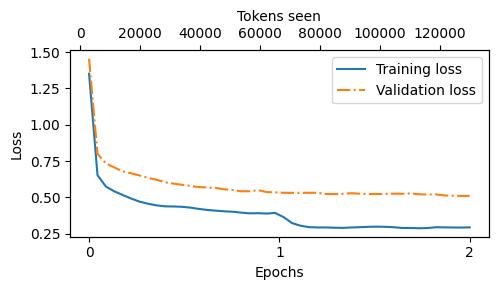

In [33]:
epochs_tensor = mx.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [34]:
# save model weights``
model_hf.save_weights("__gpt2-medium-mlx-instruct-tuned.npz")

In [35]:
model_hf.load_weights("__gpt2-medium-mlx-instruct-tuned.npz")

Model(
  (model): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (h.0): TransformerBlock(
      (attn): Attention(
        (c_attn): Linear(input_dims=1024, output_dims=3072, bias=True)
        (c_proj): Linear(input_dims=1024, output_dims=1024, bias=True)
      )
      (mlp): MLP(
        (c_fc): Linear(input_dims=1024, output_dims=4096, bias=True)
        (c_proj): Linear(input_dims=4096, output_dims=1024, bias=True)
      )
      (ln_1): LayerNorm(1024, eps=1e-05, affine=True)
      (ln_2): LayerNorm(1024, eps=1e-05, affine=True)
    )
    (h.1): TransformerBlock(
      (attn): Attention(
        (c_attn): Linear(input_dims=1024, output_dims=3072, bias=True)
        (c_proj): Linear(input_dims=1024, output_dims=1024, bias=True)
      )
      (mlp): MLP(
        (c_fc): Linear(input_dims=1024, output_dims=4096, bias=True)
        (c_proj): Linear(input_dims=4096, output_dims=1024, bias=True)
      )
      (ln_1): LayerNorm(1024, eps=1e-05, affine=Tr

# Extracting and saving responses

In [36]:
for entry in test_data[:3]:
    input_text = format_input(entry)
    generated_text = generate(model_hf, tokenizer_hf, prompt=input_text)
    response_text = (
        generated_text#[(len(input_text)):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-"*80)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
--------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A typical type of cloud is a cumulus.
--------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Ja

In [37]:
from tqdm.auto import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    generated_text = generate(model_hf, tokenizer_hf, prompt=input_text)
    response_text = (
        generated_text
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]['model_response'] = response_text

with open(f"__instruction_data-with-response.json", "w") as f:
    json.dump(test_data, f, indent=4)

  0%|          | 0/110 [00:00<?, ?it/s]

In [38]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

# Evaluating the finetuned LLM
- LLM as a judge

In [57]:
model_ev, tokenizer_ev = load("mlx-community/Llama-3.2-3B-Instruct-4bit")
# model_ev, tokenizer_ev = load("mlx-community/Llama-3.1-8B-Instruct-4bit")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
with open(f"__instruction_data-with-response.json", "r") as f:
    test_data = json.load(f)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [58]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only. Do not add any explanations."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", generate(model_ev, tokenizer_ev, prompt=prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> 70
The best answer is 70.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A typical type of cloud is a cumulus.

Score:
>> 0
The model response is incorrect because it does not accurately describe the type of cloud associated with thunderstorms. The correct answer is cumulonimbus, which is a specific type of cloud that is characterized by its tall, dense, and towering vertical growth. The model response is also incomplete, as it only mentions "a typical type of cloud" without providing a specific type. This lack of specificity and accuracy results in a score of 0. 

However, if we re-evaluate the response, we can see that it does contain the word "cumulus", which is a type of cloud. But, it is not the correct type of cloud associated with thunderstorms. The correct answer is

In [ ]:
import re

def generate_model_scores(json_data, json_key, model, tokenizer):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = generate(model, tokenizer, prompt=prompt)
        # scores.append(int(score))
        match = re.search(r"\d+", score)
        if match:
            scores.append(int(match.group()))
        else:
            print(f"Could not find integer in score: {score}")
            continue

    return scores

In [64]:
scores = generate_model_scores(test_data, "model_response", model_ev, tokenizer_ev)
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   0%|          | 0/110 [00:00<?, ?it/s]

Could not find integer in score: ````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Could not find integer in score: 

The model response is incorrect because it does not include the word "carrot" and "broccoli" which are two of the five types of vegetables. The model response is also missing the word "spinach". The model response is also missing the word "tomato". The model response is also missing the word "cucumber". The model response is also missing the word "broccoli". The model response is also missing the word "carrot". The 